In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [93]:
# Dependencies
from pymongo import MongoClient
import pandas as pd
import numpy as np
import pickle

from urls_list import * #where all urls and paths are saved

## Read the historic rental data

In [3]:
client = MongoClient(db_connection_string)
records = list(client.ETLInsights["HistoricRental"].find({}, {'_id':0}))

In [4]:
DF = pd.DataFrame(records)

In [5]:
#Replace all white spaces or nothing at all to NaN
DF.replace(r'^\s*$', np.nan, regex=True, inplace=True)
#Replace None with NaN
DF = DF.fillna(value=np.nan)

## Missing Data Analysis

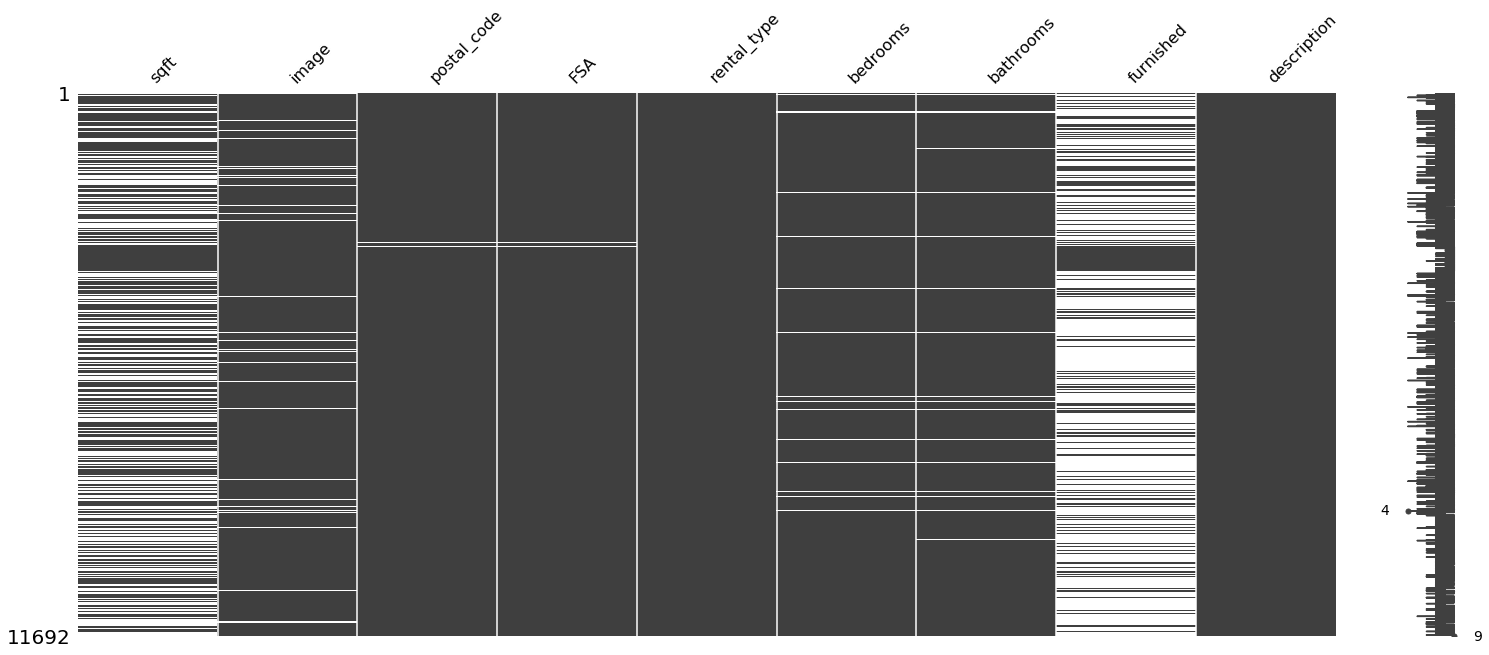

In [6]:
missingdata_col = DF.columns[DF.isnull().any()].tolist()
import matplotlib
import missingno as msno
%matplotlib inline
msno.matrix(DF[missingdata_col])

#### Make FSA and rental_type mandatory. If they are not retrieved in the rental posting, ML will not run, citing an exception

In [7]:
DF.drop(DF[DF[['FSA', 'rental_type']].isna().any(axis=1)].index, inplace=True)

# [1373, 3234, 3320, 3332, 3347, 3452, 3474, 3512, 3569, 3574, 3616,
#             3678, 3703, 3711, 3765, 3795, 3816, 3825, 7601, 8374, 8473, 8680,
#             9053, 9366, 9632]

DF = DF[DF['FSA'].str.startswith('M')]

## Type casting

In [8]:
DF['price'] = DF['price'].astype('int')

#Convert post_published_date to week of the month
from datetime import datetime
DF['post_published_date'] = DF['post_published_date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

#New features
DF['posted_week_of_month'] = DF['post_published_date'].map(lambda x: x.day//7 +1)

## Missing value handling

In [9]:
DF['furnished'] = DF['furnished'].fillna(value="NOT_MENTIONED")
DF['furnished'] = DF['furnished'].replace(to_replace=True, value='YES')
DF['furnished'] = DF['furnished'].replace(to_replace=False, value='NO')
#Convert image url to image or not?
DF['image'] = DF['image'].notna()

## Removing outliers

In [10]:
num_columns = ['sqft', 'bedrooms', 'bathrooms', 'posted_week_of_month']
cat_columns = ['image', 'FSA', 'rental_type', 'furnished', 'pet_friendly']
nlp_scope_columns = ['title', 'description']

#DF['price'].plot(kind='box',showfliers=False,showmeans=True)
#DF[num_columns].quantile(0.995)
#DF[num_columns].quantile(0.005)
#DF['price'].quantile(0.995)
#DF['price'].quantile(0.005)

#Remove sqft > 3000 and less than 200
#Remove price > 10000 and less than 100

DF = DF[(DF['price']<=10000) & (DF['price']>=100)]
DF.drop(DF[(DF['sqft']<200) | (DF['sqft']>3000)].index, axis=0, inplace=True)

## Basic Transformations

In [11]:
DF.reset_index(drop=True, inplace=True)
X = DF[num_columns + cat_columns]
Y = DF['price']

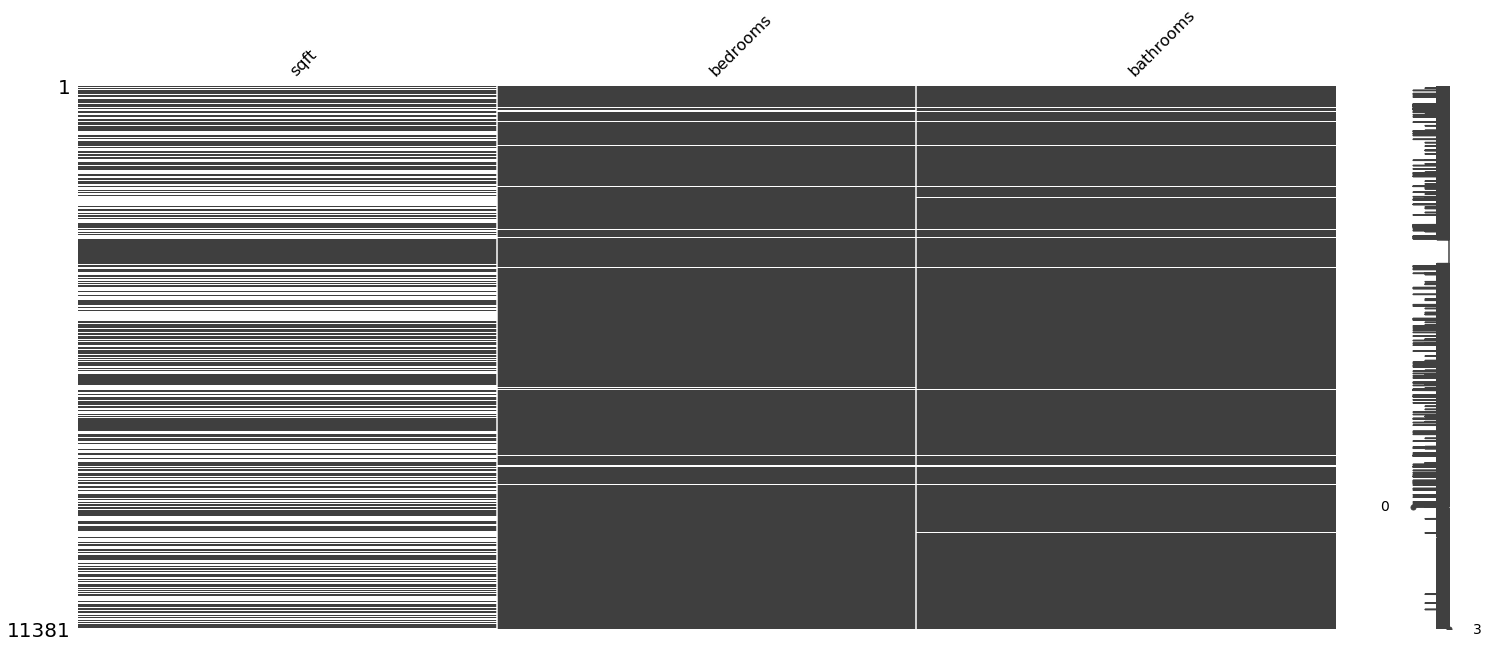

In [12]:
missingdata_col = X.columns[X.isnull().any()].tolist()
import matplotlib
import missingno as msno
%matplotlib inline
msno.matrix(X[missingdata_col])

### One Hot Encoding

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
##OHE
enc = OneHotEncoder()
##OHE Fit
enc.fit(X[cat_columns])
##OHE Transform
ohe_output = enc.transform(X[cat_columns]).toarray()
##Retrieve OHE labels
ohe_dict = {f'x{index}':col for index,col in enumerate(cat_columns)}
ohe_labels = [ohe_dict[feature.split('_')[0]]+'_'+feature.split('_')[1] for feature in enc.get_feature_names()]
X = pd.concat([X, pd.DataFrame(ohe_output, columns=ohe_labels)], axis=1)
X.drop(cat_columns, axis=1, inplace=True)

OneHotEncoder()

In [94]:
pickle.dump(enc, open('OHE.pickle', 'wb'))

## Filter only selected columns

In [23]:
selected_columns = ['sqft', 'bedrooms', 'bathrooms', 'image_False', 'FSA_M1B', 'FSA_M1M',
       'FSA_M1P', 'FSA_M1V', 'FSA_M1W', 'FSA_M2M', 'FSA_M3C', 'FSA_M3K',
       'FSA_M4E', 'FSA_M4V', 'FSA_M4W', 'FSA_M5G', 'FSA_M5J', 'FSA_M5R',
       'FSA_M5S', 'FSA_M5V', 'FSA_M6B', 'FSA_M6E', 'FSA_M6G', 'FSA_M6J',
       'FSA_M6K', 'FSA_M6M', 'FSA_M6P', 'rental_type_apartment',
       'rental_type_condo', 'rental_type_house', 'rental_type_loft',
       'rental_type_townhouse', 'furnished_NOT', 'furnished_YES',
       'pet_friendly_False']
X = X[selected_columns]

## Train Test Split

In [24]:
seed = 100
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed, test_size=0.3)


## GridSearch CV to tune XGB parameters



In [26]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_child_weight': [1, 2, 4], 
              'eta': [0.05, 0.1, 0.2, 0.3],
              'gamma' : [0.01, 0.05, 0.1, 0.2]
              }

#gamma - the higher the regularization. Default value is 0 (No regularization)
xgb_model = xgb.XGBRegressor()
gcv = GridSearchCV(
        xgb_model, 
        param_grid,
        cv=5,
        scoring = 'r2',
        verbose=5
    )
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] eta=0.05, gamma=0.01, max_depth=2, min_child_weight=1 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  eta=0.05, gamma=0.01, max_depth=2, min_child_weight=1, score=0.542, total=   0.5s
[CV] eta=0.05, gamma=0.01, max_depth=2, min_child_weight=1 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  eta=0.05, gamma=0.01, max_depth=2, min_child_weight=1, score=0.551, total=   0.4s
[CV] eta=0.05, gamma=0.01, max_depth=2, min_child_weight=1 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  eta=0.05, gamma=0.01, max_depth=2, min_child_weight=1, score=0.529, total=   0.4s
[CV] eta=0.05, gamma=0.01, max_depth=2, min_child_weight=1 ...........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV]  eta=0.05, gamma=0.01, max_depth=2, min_child_weight=1, score=0.562, total=   0.4s
[CV] eta=0.05, gamma=0.01, max_depth=2, min_child_weight=1 ...........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s


[CV]  eta=0.05, gamma=0.01, max_depth=2, min_child_weight=1, score=0.515, total=   0.5s
[CV] eta=0.05, gamma=0.01, max_depth=2, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.01, max_depth=2, min_child_weight=2, score=0.542, total=   0.4s
[CV] eta=0.05, gamma=0.01, max_depth=2, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.01, max_depth=2, min_child_weight=2, score=0.550, total=   0.4s
[CV] eta=0.05, gamma=0.01, max_depth=2, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.01, max_depth=2, min_child_weight=2, score=0.529, total=   0.4s
[CV] eta=0.05, gamma=0.01, max_depth=2, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.01, max_depth=2, min_child_weight=2, score=0.562, total=   0.4s
[CV] eta=0.05, gamma=0.01, max_depth=2, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.01, max_depth=2, min_child_weight=2, score=0.515, total=   0.4s
[CV] eta=0.05, gamma=0.01, max_depth=2, min_child_weight=4 ...........
[CV]  eta=0.05, gamma=0.01, max_depth=2, min_c

[CV]  eta=0.05, gamma=0.01, max_depth=8, min_child_weight=4, score=0.665, total=   1.8s
[CV] eta=0.05, gamma=0.01, max_depth=8, min_child_weight=4 ...........
[CV]  eta=0.05, gamma=0.01, max_depth=8, min_child_weight=4, score=0.679, total=   1.5s
[CV] eta=0.05, gamma=0.01, max_depth=8, min_child_weight=4 ...........
[CV]  eta=0.05, gamma=0.01, max_depth=8, min_child_weight=4, score=0.686, total=   1.7s
[CV] eta=0.05, gamma=0.01, max_depth=8, min_child_weight=4 ...........
[CV]  eta=0.05, gamma=0.01, max_depth=8, min_child_weight=4, score=0.677, total=   1.3s
[CV] eta=0.05, gamma=0.01, max_depth=10, min_child_weight=1 ..........
[CV]  eta=0.05, gamma=0.01, max_depth=10, min_child_weight=1, score=0.719, total=   1.8s
[CV] eta=0.05, gamma=0.01, max_depth=10, min_child_weight=1 ..........
[CV]  eta=0.05, gamma=0.01, max_depth=10, min_child_weight=1, score=0.686, total=   1.6s
[CV] eta=0.05, gamma=0.01, max_depth=10, min_child_weight=1 ..........
[CV]  eta=0.05, gamma=0.01, max_depth=10, mi

[CV]  eta=0.05, gamma=0.05, max_depth=6, min_child_weight=1, score=0.703, total=   1.1s
[CV] eta=0.05, gamma=0.05, max_depth=6, min_child_weight=1 ...........
[CV]  eta=0.05, gamma=0.05, max_depth=6, min_child_weight=1, score=0.691, total=   1.1s
[CV] eta=0.05, gamma=0.05, max_depth=6, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.05, max_depth=6, min_child_weight=2, score=0.698, total=   1.1s
[CV] eta=0.05, gamma=0.05, max_depth=6, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.05, max_depth=6, min_child_weight=2, score=0.661, total=   1.1s
[CV] eta=0.05, gamma=0.05, max_depth=6, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.05, max_depth=6, min_child_weight=2, score=0.675, total=   1.1s
[CV] eta=0.05, gamma=0.05, max_depth=6, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.05, max_depth=6, min_child_weight=2, score=0.698, total=   1.1s
[CV] eta=0.05, gamma=0.05, max_depth=6, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.05, max_depth=6, min_c

[CV]  eta=0.05, gamma=0.1, max_depth=2, min_child_weight=4, score=0.542, total=   0.4s
[CV] eta=0.05, gamma=0.1, max_depth=2, min_child_weight=4 ............
[CV]  eta=0.05, gamma=0.1, max_depth=2, min_child_weight=4, score=0.551, total=   0.4s
[CV] eta=0.05, gamma=0.1, max_depth=2, min_child_weight=4 ............
[CV]  eta=0.05, gamma=0.1, max_depth=2, min_child_weight=4, score=0.528, total=   0.4s
[CV] eta=0.05, gamma=0.1, max_depth=2, min_child_weight=4 ............
[CV]  eta=0.05, gamma=0.1, max_depth=2, min_child_weight=4, score=0.561, total=   0.4s
[CV] eta=0.05, gamma=0.1, max_depth=2, min_child_weight=4 ............
[CV]  eta=0.05, gamma=0.1, max_depth=2, min_child_weight=4, score=0.515, total=   0.5s
[CV] eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1 ............
[CV]  eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1, score=0.653, total=   0.8s
[CV] eta=0.05, gamma=0.1, max_depth=4, min_child_weight=1 ............
[CV]  eta=0.05, gamma=0.1, max_depth=4, min_child_we

[CV]  eta=0.05, gamma=0.1, max_depth=10, min_child_weight=1, score=0.659, total=   1.7s
[CV] eta=0.05, gamma=0.1, max_depth=10, min_child_weight=1 ...........
[CV]  eta=0.05, gamma=0.1, max_depth=10, min_child_weight=1, score=0.731, total=   1.6s
[CV] eta=0.05, gamma=0.1, max_depth=10, min_child_weight=1 ...........
[CV]  eta=0.05, gamma=0.1, max_depth=10, min_child_weight=1, score=0.722, total=   1.7s
[CV] eta=0.05, gamma=0.1, max_depth=10, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.1, max_depth=10, min_child_weight=2, score=0.718, total=   1.6s
[CV] eta=0.05, gamma=0.1, max_depth=10, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.1, max_depth=10, min_child_weight=2, score=0.677, total=   1.6s
[CV] eta=0.05, gamma=0.1, max_depth=10, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.1, max_depth=10, min_child_weight=2, score=0.669, total=   1.6s
[CV] eta=0.05, gamma=0.1, max_depth=10, min_child_weight=2 ...........
[CV]  eta=0.05, gamma=0.1, max_depth=10, min_c

[CV]  eta=0.05, gamma=0.2, max_depth=6, min_child_weight=2, score=0.679, total=   1.6s
[CV] eta=0.05, gamma=0.2, max_depth=6, min_child_weight=4 ............
[CV]  eta=0.05, gamma=0.2, max_depth=6, min_child_weight=4, score=0.692, total=   1.4s
[CV] eta=0.05, gamma=0.2, max_depth=6, min_child_weight=4 ............
[CV]  eta=0.05, gamma=0.2, max_depth=6, min_child_weight=4, score=0.655, total=   1.5s
[CV] eta=0.05, gamma=0.2, max_depth=6, min_child_weight=4 ............
[CV]  eta=0.05, gamma=0.2, max_depth=6, min_child_weight=4, score=0.662, total=   1.1s
[CV] eta=0.05, gamma=0.2, max_depth=6, min_child_weight=4 ............
[CV]  eta=0.05, gamma=0.2, max_depth=6, min_child_weight=4, score=0.688, total=   1.0s
[CV] eta=0.05, gamma=0.2, max_depth=6, min_child_weight=4 ............
[CV]  eta=0.05, gamma=0.2, max_depth=6, min_child_weight=4, score=0.674, total=   1.2s
[CV] eta=0.05, gamma=0.2, max_depth=8, min_child_weight=1 ............
[CV]  eta=0.05, gamma=0.2, max_depth=8, min_child_we

[CV]  eta=0.1, gamma=0.01, max_depth=4, min_child_weight=1, score=0.660, total=   0.9s
[CV] eta=0.1, gamma=0.01, max_depth=4, min_child_weight=1 ............
[CV]  eta=0.1, gamma=0.01, max_depth=4, min_child_weight=1, score=0.664, total=   1.0s
[CV] eta=0.1, gamma=0.01, max_depth=4, min_child_weight=1 ............
[CV]  eta=0.1, gamma=0.01, max_depth=4, min_child_weight=1, score=0.692, total=   0.9s
[CV] eta=0.1, gamma=0.01, max_depth=4, min_child_weight=1 ............
[CV]  eta=0.1, gamma=0.01, max_depth=4, min_child_weight=1, score=0.676, total=   1.0s
[CV] eta=0.1, gamma=0.01, max_depth=4, min_child_weight=2 ............
[CV]  eta=0.1, gamma=0.01, max_depth=4, min_child_weight=2, score=0.678, total=   0.8s
[CV] eta=0.1, gamma=0.01, max_depth=4, min_child_weight=2 ............
[CV]  eta=0.1, gamma=0.01, max_depth=4, min_child_weight=2, score=0.659, total=   0.9s
[CV] eta=0.1, gamma=0.01, max_depth=4, min_child_weight=2 ............
[CV]  eta=0.1, gamma=0.01, max_depth=4, min_child_we

[CV]  eta=0.1, gamma=0.01, max_depth=10, min_child_weight=2, score=0.724, total=   2.2s
[CV] eta=0.1, gamma=0.01, max_depth=10, min_child_weight=2 ...........
[CV]  eta=0.1, gamma=0.01, max_depth=10, min_child_weight=2, score=0.704, total=   2.0s
[CV] eta=0.1, gamma=0.01, max_depth=10, min_child_weight=4 ...........
[CV]  eta=0.1, gamma=0.01, max_depth=10, min_child_weight=4, score=0.737, total=   2.1s
[CV] eta=0.1, gamma=0.01, max_depth=10, min_child_weight=4 ...........
[CV]  eta=0.1, gamma=0.01, max_depth=10, min_child_weight=4, score=0.681, total=   1.9s
[CV] eta=0.1, gamma=0.01, max_depth=10, min_child_weight=4 ...........
[CV]  eta=0.1, gamma=0.01, max_depth=10, min_child_weight=4, score=0.680, total=   2.7s
[CV] eta=0.1, gamma=0.01, max_depth=10, min_child_weight=4 ...........
[CV]  eta=0.1, gamma=0.01, max_depth=10, min_child_weight=4, score=0.698, total=   3.1s
[CV] eta=0.1, gamma=0.01, max_depth=10, min_child_weight=4 ...........
[CV]  eta=0.1, gamma=0.01, max_depth=10, min_c

[CV]  eta=0.1, gamma=0.05, max_depth=8, min_child_weight=1, score=0.727, total=   1.5s
[CV] eta=0.1, gamma=0.05, max_depth=8, min_child_weight=1 ............
[CV]  eta=0.1, gamma=0.05, max_depth=8, min_child_weight=1, score=0.684, total=   3.2s
[CV] eta=0.1, gamma=0.05, max_depth=8, min_child_weight=1 ............
[CV]  eta=0.1, gamma=0.05, max_depth=8, min_child_weight=1, score=0.671, total=   1.7s
[CV] eta=0.1, gamma=0.05, max_depth=8, min_child_weight=1 ............
[CV]  eta=0.1, gamma=0.05, max_depth=8, min_child_weight=1, score=0.726, total=   1.7s
[CV] eta=0.1, gamma=0.05, max_depth=8, min_child_weight=1 ............
[CV]  eta=0.1, gamma=0.05, max_depth=8, min_child_weight=1, score=0.728, total=   1.9s
[CV] eta=0.1, gamma=0.05, max_depth=8, min_child_weight=2 ............
[CV]  eta=0.1, gamma=0.05, max_depth=8, min_child_weight=2, score=0.725, total=   1.5s
[CV] eta=0.1, gamma=0.05, max_depth=8, min_child_weight=2 ............
[CV]  eta=0.1, gamma=0.05, max_depth=8, min_child_we

[CV]  eta=0.1, gamma=0.1, max_depth=4, min_child_weight=2, score=0.658, total=   0.8s
[CV] eta=0.1, gamma=0.1, max_depth=4, min_child_weight=2 .............
[CV]  eta=0.1, gamma=0.1, max_depth=4, min_child_weight=2, score=0.693, total=   0.9s
[CV] eta=0.1, gamma=0.1, max_depth=4, min_child_weight=2 .............
[CV]  eta=0.1, gamma=0.1, max_depth=4, min_child_weight=2, score=0.668, total=   0.8s
[CV] eta=0.1, gamma=0.1, max_depth=4, min_child_weight=4 .............
[CV]  eta=0.1, gamma=0.1, max_depth=4, min_child_weight=4, score=0.679, total=   0.9s
[CV] eta=0.1, gamma=0.1, max_depth=4, min_child_weight=4 .............
[CV]  eta=0.1, gamma=0.1, max_depth=4, min_child_weight=4, score=0.658, total=   0.8s
[CV] eta=0.1, gamma=0.1, max_depth=4, min_child_weight=4 .............
[CV]  eta=0.1, gamma=0.1, max_depth=4, min_child_weight=4, score=0.649, total=   0.8s
[CV] eta=0.1, gamma=0.1, max_depth=4, min_child_weight=4 .............
[CV]  eta=0.1, gamma=0.1, max_depth=4, min_child_weight=4,

[CV]  eta=0.1, gamma=0.2, max_depth=2, min_child_weight=1, score=0.588, total=   0.4s
[CV] eta=0.1, gamma=0.2, max_depth=2, min_child_weight=1 .............
[CV]  eta=0.1, gamma=0.2, max_depth=2, min_child_weight=1, score=0.592, total=   0.4s
[CV] eta=0.1, gamma=0.2, max_depth=2, min_child_weight=1 .............
[CV]  eta=0.1, gamma=0.2, max_depth=2, min_child_weight=1, score=0.566, total=   0.5s
[CV] eta=0.1, gamma=0.2, max_depth=2, min_child_weight=1 .............
[CV]  eta=0.1, gamma=0.2, max_depth=2, min_child_weight=1, score=0.607, total=   0.5s
[CV] eta=0.1, gamma=0.2, max_depth=2, min_child_weight=1 .............
[CV]  eta=0.1, gamma=0.2, max_depth=2, min_child_weight=1, score=0.564, total=   0.5s
[CV] eta=0.1, gamma=0.2, max_depth=2, min_child_weight=2 .............
[CV]  eta=0.1, gamma=0.2, max_depth=2, min_child_weight=2, score=0.590, total=   0.4s
[CV] eta=0.1, gamma=0.2, max_depth=2, min_child_weight=2 .............
[CV]  eta=0.1, gamma=0.2, max_depth=2, min_child_weight=2,

[CV]  eta=0.1, gamma=0.2, max_depth=8, min_child_weight=2, score=0.719, total=   1.4s
[CV] eta=0.1, gamma=0.2, max_depth=8, min_child_weight=2 .............
[CV]  eta=0.1, gamma=0.2, max_depth=8, min_child_weight=2, score=0.716, total=   1.3s
[CV] eta=0.1, gamma=0.2, max_depth=8, min_child_weight=4 .............
[CV]  eta=0.1, gamma=0.2, max_depth=8, min_child_weight=4, score=0.732, total=   1.5s
[CV] eta=0.1, gamma=0.2, max_depth=8, min_child_weight=4 .............
[CV]  eta=0.1, gamma=0.2, max_depth=8, min_child_weight=4, score=0.674, total=   1.6s
[CV] eta=0.1, gamma=0.2, max_depth=8, min_child_weight=4 .............
[CV]  eta=0.1, gamma=0.2, max_depth=8, min_child_weight=4, score=0.680, total=   1.6s
[CV] eta=0.1, gamma=0.2, max_depth=8, min_child_weight=4 .............
[CV]  eta=0.1, gamma=0.2, max_depth=8, min_child_weight=4, score=0.698, total=   2.1s
[CV] eta=0.1, gamma=0.2, max_depth=8, min_child_weight=4 .............
[CV]  eta=0.1, gamma=0.2, max_depth=8, min_child_weight=4,

[CV]  eta=0.2, gamma=0.01, max_depth=6, min_child_weight=1, score=0.723, total=   1.3s
[CV] eta=0.2, gamma=0.01, max_depth=6, min_child_weight=1 ............
[CV]  eta=0.2, gamma=0.01, max_depth=6, min_child_weight=1, score=0.687, total=   1.9s
[CV] eta=0.2, gamma=0.01, max_depth=6, min_child_weight=1 ............
[CV]  eta=0.2, gamma=0.01, max_depth=6, min_child_weight=1, score=0.682, total=   2.4s
[CV] eta=0.2, gamma=0.01, max_depth=6, min_child_weight=1 ............
[CV]  eta=0.2, gamma=0.01, max_depth=6, min_child_weight=1, score=0.714, total=   1.3s
[CV] eta=0.2, gamma=0.01, max_depth=6, min_child_weight=1 ............
[CV]  eta=0.2, gamma=0.01, max_depth=6, min_child_weight=1, score=0.724, total=   1.3s
[CV] eta=0.2, gamma=0.01, max_depth=6, min_child_weight=2 ............
[CV]  eta=0.2, gamma=0.01, max_depth=6, min_child_weight=2, score=0.728, total=   1.5s
[CV] eta=0.2, gamma=0.01, max_depth=6, min_child_weight=2 ............
[CV]  eta=0.2, gamma=0.01, max_depth=6, min_child_we

[CV]  eta=0.2, gamma=0.05, max_depth=2, min_child_weight=2, score=0.590, total=   0.4s
[CV] eta=0.2, gamma=0.05, max_depth=2, min_child_weight=2 ............
[CV]  eta=0.2, gamma=0.05, max_depth=2, min_child_weight=2, score=0.646, total=   0.9s
[CV] eta=0.2, gamma=0.05, max_depth=2, min_child_weight=2 ............
[CV]  eta=0.2, gamma=0.05, max_depth=2, min_child_weight=2, score=0.612, total=   0.6s
[CV] eta=0.2, gamma=0.05, max_depth=2, min_child_weight=4 ............
[CV]  eta=0.2, gamma=0.05, max_depth=2, min_child_weight=4, score=0.626, total=   0.4s
[CV] eta=0.2, gamma=0.05, max_depth=2, min_child_weight=4 ............
[CV]  eta=0.2, gamma=0.05, max_depth=2, min_child_weight=4, score=0.612, total=   0.5s
[CV] eta=0.2, gamma=0.05, max_depth=2, min_child_weight=4 ............
[CV]  eta=0.2, gamma=0.05, max_depth=2, min_child_weight=4, score=0.597, total=   0.4s
[CV] eta=0.2, gamma=0.05, max_depth=2, min_child_weight=4 ............
[CV]  eta=0.2, gamma=0.05, max_depth=2, min_child_we

[CV]  eta=0.2, gamma=0.05, max_depth=8, min_child_weight=4, score=0.698, total=   2.6s
[CV] eta=0.2, gamma=0.05, max_depth=10, min_child_weight=1 ...........
[CV]  eta=0.2, gamma=0.05, max_depth=10, min_child_weight=1, score=0.706, total=   2.4s
[CV] eta=0.2, gamma=0.05, max_depth=10, min_child_weight=1 ...........
[CV]  eta=0.2, gamma=0.05, max_depth=10, min_child_weight=1, score=0.684, total=   2.7s
[CV] eta=0.2, gamma=0.05, max_depth=10, min_child_weight=1 ...........
[CV]  eta=0.2, gamma=0.05, max_depth=10, min_child_weight=1, score=0.646, total=   2.7s
[CV] eta=0.2, gamma=0.05, max_depth=10, min_child_weight=1 ...........
[CV]  eta=0.2, gamma=0.05, max_depth=10, min_child_weight=1, score=0.727, total=   3.6s
[CV] eta=0.2, gamma=0.05, max_depth=10, min_child_weight=1 ...........
[CV]  eta=0.2, gamma=0.05, max_depth=10, min_child_weight=1, score=0.716, total=   2.7s
[CV] eta=0.2, gamma=0.05, max_depth=10, min_child_weight=2 ...........
[CV]  eta=0.2, gamma=0.05, max_depth=10, min_ch

[CV]  eta=0.2, gamma=0.1, max_depth=6, min_child_weight=2, score=0.675, total=   1.1s
[CV] eta=0.2, gamma=0.1, max_depth=6, min_child_weight=2 .............
[CV]  eta=0.2, gamma=0.1, max_depth=6, min_child_weight=2, score=0.688, total=   1.0s
[CV] eta=0.2, gamma=0.1, max_depth=6, min_child_weight=2 .............
[CV]  eta=0.2, gamma=0.1, max_depth=6, min_child_weight=2, score=0.714, total=   1.0s
[CV] eta=0.2, gamma=0.1, max_depth=6, min_child_weight=2 .............
[CV]  eta=0.2, gamma=0.1, max_depth=6, min_child_weight=2, score=0.711, total=   1.1s
[CV] eta=0.2, gamma=0.1, max_depth=6, min_child_weight=4 .............
[CV]  eta=0.2, gamma=0.1, max_depth=6, min_child_weight=4, score=0.727, total=   1.1s
[CV] eta=0.2, gamma=0.1, max_depth=6, min_child_weight=4 .............
[CV]  eta=0.2, gamma=0.1, max_depth=6, min_child_weight=4, score=0.673, total=   1.2s
[CV] eta=0.2, gamma=0.1, max_depth=6, min_child_weight=4 .............
[CV]  eta=0.2, gamma=0.1, max_depth=6, min_child_weight=4,

[CV]  eta=0.2, gamma=0.2, max_depth=2, min_child_weight=4, score=0.614, total=   0.7s
[CV] eta=0.2, gamma=0.2, max_depth=4, min_child_weight=1 .............
[CV]  eta=0.2, gamma=0.2, max_depth=4, min_child_weight=1, score=0.711, total=   0.8s
[CV] eta=0.2, gamma=0.2, max_depth=4, min_child_weight=1 .............
[CV]  eta=0.2, gamma=0.2, max_depth=4, min_child_weight=1, score=0.672, total=   0.8s
[CV] eta=0.2, gamma=0.2, max_depth=4, min_child_weight=1 .............
[CV]  eta=0.2, gamma=0.2, max_depth=4, min_child_weight=1, score=0.660, total=   0.9s
[CV] eta=0.2, gamma=0.2, max_depth=4, min_child_weight=1 .............
[CV]  eta=0.2, gamma=0.2, max_depth=4, min_child_weight=1, score=0.709, total=   0.9s
[CV] eta=0.2, gamma=0.2, max_depth=4, min_child_weight=1 .............
[CV]  eta=0.2, gamma=0.2, max_depth=4, min_child_weight=1, score=0.701, total=   0.8s
[CV] eta=0.2, gamma=0.2, max_depth=4, min_child_weight=2 .............
[CV]  eta=0.2, gamma=0.2, max_depth=4, min_child_weight=2,

[CV]  eta=0.2, gamma=0.2, max_depth=10, min_child_weight=2, score=0.669, total=   1.6s
[CV] eta=0.2, gamma=0.2, max_depth=10, min_child_weight=2 ............
[CV]  eta=0.2, gamma=0.2, max_depth=10, min_child_weight=2, score=0.730, total=   1.6s
[CV] eta=0.2, gamma=0.2, max_depth=10, min_child_weight=2 ............
[CV]  eta=0.2, gamma=0.2, max_depth=10, min_child_weight=2, score=0.708, total=   1.6s
[CV] eta=0.2, gamma=0.2, max_depth=10, min_child_weight=4 ............
[CV]  eta=0.2, gamma=0.2, max_depth=10, min_child_weight=4, score=0.741, total=   1.8s
[CV] eta=0.2, gamma=0.2, max_depth=10, min_child_weight=4 ............
[CV]  eta=0.2, gamma=0.2, max_depth=10, min_child_weight=4, score=0.684, total=   1.7s
[CV] eta=0.2, gamma=0.2, max_depth=10, min_child_weight=4 ............
[CV]  eta=0.2, gamma=0.2, max_depth=10, min_child_weight=4, score=0.666, total=   1.7s
[CV] eta=0.2, gamma=0.2, max_depth=10, min_child_weight=4 ............
[CV]  eta=0.2, gamma=0.2, max_depth=10, min_child_we

[CV]  eta=0.3, gamma=0.01, max_depth=6, min_child_weight=4, score=0.719, total=   0.9s
[CV] eta=0.3, gamma=0.01, max_depth=8, min_child_weight=1 ............
[CV]  eta=0.3, gamma=0.01, max_depth=8, min_child_weight=1, score=0.720, total=   1.2s
[CV] eta=0.3, gamma=0.01, max_depth=8, min_child_weight=1 ............
[CV]  eta=0.3, gamma=0.01, max_depth=8, min_child_weight=1, score=0.676, total=   1.3s
[CV] eta=0.3, gamma=0.01, max_depth=8, min_child_weight=1 ............
[CV]  eta=0.3, gamma=0.01, max_depth=8, min_child_weight=1, score=0.671, total=   1.2s
[CV] eta=0.3, gamma=0.01, max_depth=8, min_child_weight=1 ............
[CV]  eta=0.3, gamma=0.01, max_depth=8, min_child_weight=1, score=0.720, total=   1.2s
[CV] eta=0.3, gamma=0.01, max_depth=8, min_child_weight=1 ............
[CV]  eta=0.3, gamma=0.01, max_depth=8, min_child_weight=1, score=0.714, total=   1.2s
[CV] eta=0.3, gamma=0.01, max_depth=8, min_child_weight=2 ............
[CV]  eta=0.3, gamma=0.01, max_depth=8, min_child_we

[CV]  eta=0.3, gamma=0.05, max_depth=4, min_child_weight=2, score=0.684, total=   0.6s
[CV] eta=0.3, gamma=0.05, max_depth=4, min_child_weight=2 ............
[CV]  eta=0.3, gamma=0.05, max_depth=4, min_child_weight=2, score=0.672, total=   0.7s
[CV] eta=0.3, gamma=0.05, max_depth=4, min_child_weight=2 ............
[CV]  eta=0.3, gamma=0.05, max_depth=4, min_child_weight=2, score=0.705, total=   0.7s
[CV] eta=0.3, gamma=0.05, max_depth=4, min_child_weight=2 ............
[CV]  eta=0.3, gamma=0.05, max_depth=4, min_child_weight=2, score=0.703, total=   0.6s
[CV] eta=0.3, gamma=0.05, max_depth=4, min_child_weight=4 ............
[CV]  eta=0.3, gamma=0.05, max_depth=4, min_child_weight=4, score=0.710, total=   0.7s
[CV] eta=0.3, gamma=0.05, max_depth=4, min_child_weight=4 ............
[CV]  eta=0.3, gamma=0.05, max_depth=4, min_child_weight=4, score=0.661, total=   0.7s
[CV] eta=0.3, gamma=0.05, max_depth=4, min_child_weight=4 ............
[CV]  eta=0.3, gamma=0.05, max_depth=4, min_child_we

[CV]  eta=0.3, gamma=0.05, max_depth=10, min_child_weight=4, score=0.701, total=   1.5s
[CV] eta=0.3, gamma=0.05, max_depth=10, min_child_weight=4 ...........
[CV]  eta=0.3, gamma=0.05, max_depth=10, min_child_weight=4, score=0.704, total=   1.5s
[CV] eta=0.3, gamma=0.1, max_depth=2, min_child_weight=1 .............
[CV]  eta=0.3, gamma=0.1, max_depth=2, min_child_weight=1, score=0.647, total=   0.4s
[CV] eta=0.3, gamma=0.1, max_depth=2, min_child_weight=1 .............
[CV]  eta=0.3, gamma=0.1, max_depth=2, min_child_weight=1, score=0.620, total=   0.4s
[CV] eta=0.3, gamma=0.1, max_depth=2, min_child_weight=1 .............
[CV]  eta=0.3, gamma=0.1, max_depth=2, min_child_weight=1, score=0.595, total=   0.4s
[CV] eta=0.3, gamma=0.1, max_depth=2, min_child_weight=1 .............
[CV]  eta=0.3, gamma=0.1, max_depth=2, min_child_weight=1, score=0.662, total=   0.4s
[CV] eta=0.3, gamma=0.1, max_depth=2, min_child_weight=1 .............
[CV]  eta=0.3, gamma=0.1, max_depth=2, min_child_weigh

[CV]  eta=0.3, gamma=0.1, max_depth=8, min_child_weight=2, score=0.680, total=   2.0s
[CV] eta=0.3, gamma=0.1, max_depth=8, min_child_weight=2 .............
[CV]  eta=0.3, gamma=0.1, max_depth=8, min_child_weight=2, score=0.684, total=   2.1s
[CV] eta=0.3, gamma=0.1, max_depth=8, min_child_weight=2 .............
[CV]  eta=0.3, gamma=0.1, max_depth=8, min_child_weight=2, score=0.715, total=   2.0s
[CV] eta=0.3, gamma=0.1, max_depth=8, min_child_weight=2 .............
[CV]  eta=0.3, gamma=0.1, max_depth=8, min_child_weight=2, score=0.700, total=   1.4s
[CV] eta=0.3, gamma=0.1, max_depth=8, min_child_weight=4 .............
[CV]  eta=0.3, gamma=0.1, max_depth=8, min_child_weight=4, score=0.736, total=   1.3s
[CV] eta=0.3, gamma=0.1, max_depth=8, min_child_weight=4 .............
[CV]  eta=0.3, gamma=0.1, max_depth=8, min_child_weight=4, score=0.678, total=   1.4s
[CV] eta=0.3, gamma=0.1, max_depth=8, min_child_weight=4 .............
[CV]  eta=0.3, gamma=0.1, max_depth=8, min_child_weight=4,

[CV]  eta=0.3, gamma=0.2, max_depth=4, min_child_weight=4, score=0.702, total=   0.8s
[CV] eta=0.3, gamma=0.2, max_depth=6, min_child_weight=1 .............
[CV]  eta=0.3, gamma=0.2, max_depth=6, min_child_weight=1, score=0.739, total=   1.3s
[CV] eta=0.3, gamma=0.2, max_depth=6, min_child_weight=1 .............
[CV]  eta=0.3, gamma=0.2, max_depth=6, min_child_weight=1, score=0.690, total=   1.4s
[CV] eta=0.3, gamma=0.2, max_depth=6, min_child_weight=1 .............
[CV]  eta=0.3, gamma=0.2, max_depth=6, min_child_weight=1, score=0.692, total=   1.4s
[CV] eta=0.3, gamma=0.2, max_depth=6, min_child_weight=1 .............
[CV]  eta=0.3, gamma=0.2, max_depth=6, min_child_weight=1, score=0.728, total=   1.3s
[CV] eta=0.3, gamma=0.2, max_depth=6, min_child_weight=1 .............
[CV]  eta=0.3, gamma=0.2, max_depth=6, min_child_weight=1, score=0.708, total=   1.2s
[CV] eta=0.3, gamma=0.2, max_depth=6, min_child_weight=2 .............
[CV]  eta=0.3, gamma=0.2, max_depth=6, min_child_weight=2,

[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed: 25.4min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [29]:
gcv.best_params_
best_param = gcv.best_params_

{'eta': 0.2, 'gamma': 0.01, 'max_depth': 8, 'min_child_weight': 1}

## Base Model

Choose XGB model

In [87]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(**best_param)#objective='reg:squarederror'
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0.01,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [95]:
pickle.dump(xgb_model, open('xgb_model.pickle', 'wb'))

In [88]:
y_pred = xgb_model.predict(X_test)

In [89]:
xgb_model.score(X_train, y_train)

0.8740743829486558

In [90]:
xgb_model.score(X_test, y_test)


0.7137219899845428

In [91]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(y_test, y_pred)
np.sqrt(mean_squared_error(y_test, y_pred))
# np.sqrt(np.mean((y_pred-y_test)**2))

0.7137219899845428

457.09609029625324